In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

In [15]:
multicore_out_path = "./results_multicore"
singlecore_out_path = "./results_singlecore"

trace_combination_filename = "multicore_traces.txt"
3
trace_combs = {}
with open(trace_combination_filename, "r") as trace_combination_file:
    for line in trace_combination_file:
        line = line.strip()
        if(line == ""):
            continue
        trace_name = line.split(",")[0]
        trace_list = line.split(",")[1:]
        trace_combs[trace_name] = trace_list

ipc_alone = {}

result_path = singlecore_out_path + "/NoDefense/stats/"
result_list = [x[:-4] for x in os.listdir(result_path) if (x.endswith(".txt") and x.startswith("100"))]
for result_filename in result_list:
    result_file = open(result_path + "/" + result_filename + ".txt", "r")
    trace = result_filename.split("_")[1]
    core_0 = 0
    for line in result_file.readlines():
        if (" cycles_recorded_core_0:" in line):
            core_0 = int(line.split(" ")[-1])
    ipc_alone[trace] = 100000000 / core_0
    result_file.close()

df = pd.DataFrame(columns=["mitigation", "trh", "trace", "ws"])
mitigation_list = ["PARA", "Hydra", "TWiCe-Ideal", "Graphene", "RRS", "OracleRH", "PrIDE", "MINT2", "NoDefense"]
# mitigation_list = ["PrIDE", "NoDefence"]
for mitigation in mitigation_list:
    result_path = multicore_out_path + "/" + mitigation + "/stats/"
    result_list = [x[:-4] for x in os.listdir(result_path) if x.endswith(".txt")]
    for result_filename in result_list:
        result_file = open(result_path + "/" + result_filename + ".txt", "r")
        trh = int(result_filename.split("_")[0])
        trace = result_filename.split("_")[1]
        ipc_0 = 0
        ipc_1 = 0
        ipc_2 = 0
        ipc_3 = 0
        trace_0, trace_1, trace_2, trace_3 = trace_combs[trace]
        for line in result_file.readlines():
            if (" cycles_recorded_core_0:" in line):
                ipc_0 = 100000000 / int(line.split(" ")[-1])
            if (" cycles_recorded_core_1:" in line):
                ipc_1 = 100000000 / int(line.split(" ")[-1])
            if (" cycles_recorded_core_2:" in line):
                ipc_2 = 100000000 / int(line.split(" ")[-1])
            if (" cycles_recorded_core_3:" in line):
                ipc_3 = 100000000 / int(line.split(" ")[-1])
        if (ipc_0 == 0 and ipc_1 == 0 and ipc_2 == 0 and ipc_3 == 0):
            continue
        if (ipc_0 == 0 or ipc_1 == 0 or ipc_2 == 0 or ipc_3 == 0):
            print("Error: " + result_filename)

        
        weighted_speedup = ipc_0 / ipc_alone[trace_0] + ipc_1 / ipc_alone[trace_1] + ipc_2 / ipc_alone[trace_2] + ipc_3 / ipc_alone[trace_3]
        
        result_file.close()
        df = pd.concat([df, pd.DataFrame([{'mitigation': mitigation, 'trh': trh, 'trace': trace, 'ws': weighted_speedup}])], ignore_index=True)
        # df = df.append({'mitigation': mitigation, 'trh': trh, 'trace': trace, 'ws': weighted_speedup}, ignore_index=True)
    
df = df.pivot(index=['trh', 'trace'], columns=['mitigation'], values='ws').reset_index()
for mitigation in set(mitigation_list) - set(['NoDefense']):
    df[mitigation] = df[mitigation] / df['NoDefense']

df['NoDefense'] = 1
df.drop(['NoDefense'], axis = 1, inplace=True)
df.rename(columns={'OracleRH': 'Ideal'}, inplace=True)
df = df.melt(id_vars=['trh', 'trace'], var_name='mitigation', value_name='norm_ws')


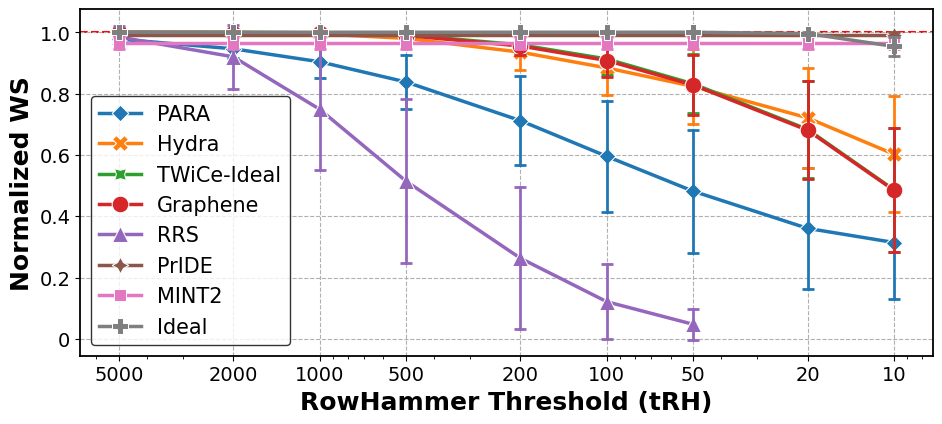

In [17]:
fig, ax = plt.subplots(figsize=(11, 4.5))

# plot the data as a line plot with markers and errorbars with larger markers and put ticks at both ends of the errorbars
sns.lineplot(x='trh', y='norm_ws', hue='mitigation', data=df, ax=ax, 
             linewidth=2.5,
             markers=True, dashes=False, style='mitigation', markersize=12, errorbar=("sd"), err_style='bars',
             hue_order=['PARA', 'Hydra', 'TWiCe-Ideal', 'Graphene', 'RRS', 'PrIDE', 'MINT2', 'Ideal'],
             err_kws={'capsize': 4, 'elinewidth': 2, 'capthick': 2}
             )

plt.grid(axis='both', linestyle='--')
#make x axis reversed
plt.gca().invert_xaxis()
plt.xscale('log')

x_ticks = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks, fontsize=14)

y_ticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
ax.axhline(y=1.0, color='red', linestyle='--', zorder=0)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks, fontsize=14)

ax.set_xlabel("RowHammer Threshold (tRH)", fontsize=18, weight="bold")
ax.set_ylabel("Normalized WS", fontsize=18, weight="bold")

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.3)

# plt.legend(bbox_to_anchor=(0.5, 1.12), loc='upper center', ncol=6,
#             fontsize=12,
#             edgecolor='black'
#            )

plt.legend(loc='lower left', ncol=1,
            fontsize=15,
            edgecolor='black'
           )

In [ ]:
fig2, ax2 = plt.subplots(figsize=(11, 4.5))